In [2]:
import pandas as pd
from datetime import datetime, date
import numpy as np
import seaborn as sns
import matplotlib as mpl
import inspect
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, skew, kurtosis, ks_2samp, mannwhitneyu
import statsmodels.stats.weightstats as smws

%matplotlib inline

import os
import pandas as pd
import openpyxl as excel
import glob

print(sns.__version__)

0.13.0.dev0


In [3]:
dir_ = "/home/reinhold/Daten/Paper_Datasets_Nov2022"
filenames = [r'OpenAPS complete_patient_statistics.xlsx',
    r'OPENonOH complete_patient_statistics.xlsx'] # Specify the file path

df = {}
df["OpenAPS"] = pd.read_excel(os.path.join(dir_, filenames[0]))  # all columns
df["OpenAPS"]["TOR"] = df["OpenAPS"]["TOR<70"].astype("float64") + df["OpenAPS"]["TOR>180"].astype("float64")
df["OPENonOH"] = pd.read_excel(os.path.join(dir_, filenames[1]))
print(len(df["OPENonOH"].columns), df["OPENonOH"].columns)
df["OPENonOH"]["TOR"] = df["OPENonOH"]["TOR<70"].astype("float64") + df["OPENonOH"]["TOR>180"].astype("float64")
print(sns.__version__)

27 Index([         'id',         'age',      'gender',      'height',
            'weight',     'country',        'year',       'month',
        'interdaysd',  'interdaycv', 'bg_roc_stds',      'TOR<70',
               'TIR',     'TOR>180',         'POR',     'J_index',
              'LGBI',        'HBGI',         'GMI',       'count',
              'mean',         'std',         'min',          0.25,
                 0.5,          0.75,         'max'],
      dtype='object')
0.13.0.dev0


In [4]:
#print([p for p in plt.rcParams.keys() if "font" in p])


# Statistical and Variability Metrics for Glucose Analysis from CGM Data

count - total CGM data points

mean - average of CGM data

std	- standard deviation of CGM data

min	- minimum CGM data value

25%	- Q1

50%	- Q2

75%	- Q3 

max - maximum CGM data value

interdaysd - computes interday standard deviation

interdaycv - computes interday coefficient of variation

TORless70 - computes time outside range --> (hypoglycemia | BG < 70 mg/dL) in percentage

TIR - computes time inside range --> (target range | 70 mg/dl < BG < 180 mg/dL) in percentage

TORmore180 - computes time outside range --> (hyperglycemia | BG > 180 mg/dL) in percentage

TOR - computes percent of time outside range (range in standard deviations from mean, default = 1). sr is the sampling rate inverse in minutes of the CGM 

J_index - computes the glycemic variability metric, J-index

LBGI - computes glycemic variability metric low blood glucose index

HBGI - computes glycemic variability metric high blood glucose index

GMI - computes glycemic management indicator

In [5]:
df1, df2 = df["OPENonOH"], df["OpenAPS"]
var = "interdaysd"
#print(plt.rcParams.keys())

df1.loc[df1['gender'] == 'Transgender Male',
                        'gender'] = 'Male'
df2.loc[df2['gender'] == 'Transgender Male',
                        'gender'] = 'Male'
df1["project"] = "OPENonOH"
df2["project"] = "OpenAPS\nData\nCommons"
print(df1.index, df2.index)
df1.reindex(["id"], axis=0)
print(df1.index, df2.index)

df3 = pd.concat([df1, df2], axis=0)
print(df3.loc[df3[["project", "id"]].duplicated(keep=False)])
#df3.reindex(["project", "id"], axis=0)

#h, bin_edges = np.histogram(df1.loc[df1['gender']=='Male',var])
#kernel = gaussian_kde(df1.loc[df1['gender']=='Male',var])
#x = np.linspace(bin_edges[0], bin_edges[-1], 100)
#sns.lineplot(x=x, y=kernel(x)*75*(bin_edges[1]-bin_edges[0]))

#sns.histplot(data=df2,
#            x=var, 
#            hue='gender',
#           palette=["#0672B0", "brown"],
#            linewidth=1, 
#            legend=None)
#plt.hist(df["OpenAPS"][var])


RangeIndex(start=0, stop=75, step=1) RangeIndex(start=0, stop=122, step=1)
RangeIndex(start=0, stop=75, step=1) RangeIndex(start=0, stop=122, step=1)
Empty DataFrame
Columns: [id, age, gender, height, weight, country, year, month, interdaysd, interdaycv, bg_roc_stds, TOR<70, TIR, TOR>180, POR, J_index, LGBI, HBGI, GMI, count, mean, std, min, 0.25, 0.5, 0.75, max, TOR, project, Unnamed: 0, mean+std, mean-std, dailyInsulinUnits, dailyBasalInsulinUnits, DIYTech]
Index: []

[0 rows x 35 columns]


# Visualising demographics and calculated metrics
Figure 5 in the gv paper (https://www.mdpi.com/2072-6643/14/9/1906)

In [6]:

def plot_kde_two_distributions(df1, df2, var, xlabel):
    sns.set_theme(context="notebook", style="white")
    #sns.set_theme(rc={'palette': ["#0672B0", "brown"], 'alpha' : 0.5, 'linewidth' : 0.1, 'kde' : True, 'rug':True})

    df1[var] = df1[var].astype(float)
    df2[var] = df2[var].astype(float)

    plt.rcParams.update({'font.size': 24})
    nbins = 8  # number of bins
    fg= sns.displot(df1,
                x=df1[var],
                hue=df1['gender'],
                palette=["brown", "#0672B0"],
                alpha=0.5,
                linewidth=0.1,
                bins=nbins,
                kde=True, 
                rug=True)
    plt.xlabel(xlabel)

    print(len(fg.fig.axes))
    ax = fg.fig.axes[0]
    print(len(ax.get_lines()))
    ax.get_lines().remove(ax.get_lines()[1])
    min_,max_ = ax.get_xlim()
    bin_width = (max_-min_)/nbins
    #print(df2['gender'].unique())
    h,kernel,norm_ = {}, {}, {}
    kernel["Male"] = gaussian_kde(df2.loc[df2['gender']=='Male',var])
    x_ = np.linspace(min_, max_, 100)
    print(df2.loc[df2['gender']=='Female', 'gender'].count())
    norm_["Female"] = df2.loc[df2['gender']=='Female', 'gender'].count()*bin_width  
    norm_["Male"] = df2.loc[df2['gender']=='Male', 'gender'].count()*bin_width  

    kernel["Female"] = gaussian_kde(df2.loc[df2['gender']=='Female',var])
    sns.lineplot(x=x_, y=kernel["Female"](x_)*norm_["Female"], ax=ax, color="brown", linestyle='--', label="F (OpenAPS)")
    sns.lineplot(x=x_, y=kernel["Male"](x_)*norm_["Male"], ax=ax, color="#0672B0", linestyle='--', label="M (OpenAPS)")

    fg.fig.savefig("kde_"+var+".png", bbox_inches='tight')
    #h["Male"], bin_edges["Male"] = np.histogram(df1.loc[df1['gender']=='Male',var])
    #kernel["Male"] = gaussian_kde(df1.loc[df1['gender']=='Male',var])
    #x["Male"] = np.linspace(bin_edges["Male"][0], bin_edges["Male"][-1], 100)
    #norm_ = 75*(bin_edges["Male"][1]-bin_edges["Male"][0])
    #sns.lineplot(x=x["Male"], y=kernel["Male"](x["Male"])*norm_, ax=ax, color="brown")


In [7]:
def plot_kde2(df, var, xlabel, move_legend=False):
    sns.set_theme(context="notebook", style="white")
    #sns.set_theme(rc={'alpha' : 0.5, 'linewidth' : 0.1, 'kde' : True, 'rug':True})
    
    df[var] = df[var].astype(float)

    plt.rcParams.update({'font.size': 30, 'legend.fontsize': 16, 'legend.title_fontsize': 16, 'axes.labelsize': 16, 'axes.titlesize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16})
    #plt.rcParams.update({'font.size': 30, 'legend.fontsize': 18, 'legend.title_fontsize': 20, 'legend.title_fontcolor': 'white'})
    nbins = 8  # number of bins
    fg= sns.displot(df,
                x=df[var],
                hue=df['project'],
                palette=["brown", "#0672B0"],
                alpha=0.5,
                linewidth=0.1,
                bins=nbins,
                kde=True, 
                rug=True)
    plt.xlabel(xlabel)
    plt.tight_layout()
    if move_legend: 
        sns.move_legend(fg, title="", loc='upper left', bbox_to_anchor=(0.15, 0.92), ncol=1)
    else:
        sns.move_legend(fg, title="", loc='center right', ncol=1)
    plt.savefig("kde_"+var+"_2.png")

    # calculate stats:
    x = df.loc[df['project']=='OpenAPS\nData\nCommons', var].tolist()
    IQR_x = np.percentile(x, 75) - np.percentile(x, 25)
    y = df.loc[df['project']=='OPENonOH', var].tolist()
    IQR_y = np.percentile(x, 75) - np.percentile(x, 25)
    
    z_statistic, p_value = smws.ztest(x, y)
    ks_statistic, p_value_ks = ks_2samp(x, y)
    mw_statistic, p_value_mw = mannwhitneyu(x, y)

    out = [np.mean(x), np.std(x), np.min(x), np.max(x), np.median(x), np.percentile(x, 25), np.percentile(x, 75), IQR_x, len(x), skew(x), kurtosis(x)]
    out.extend([np.mean(y), np.std(y), np.min(y), np.max(y), np.median(y), np.percentile(y, 25), np.percentile(y, 75), IQR_y, len(y), skew(y), kurtosis(y)])
    out.extend([z_statistic, p_value, ks_statistic, p_value_ks, mw_statistic, p_value_mw])
    return out

In [8]:
#plt.rcParams.keys()

Index([                    'id',                    'age',
                       'gender',                 'height',
                       'weight',                'country',
                         'year',                  'month',
                   'interdaysd',             'interdaycv',
                  'bg_roc_stds',                 'TOR<70',
                          'TIR',                'TOR>180',
                          'POR',                'J_index',
                         'LGBI',                   'HBGI',
                          'GMI',                  'count',
                         'mean',                    'std',
                          'min',                     0.25,
                            0.5,                     0.75,
                          'max',                    'TOR',
                      'project',             'Unnamed: 0',
                     'mean+std',               'mean-std',
            'dailyInsulinUnits', 'dailyBasalInsulinUnits

ValueError: Length mismatch: Expected axis has 10 elements, new values have 8 elements

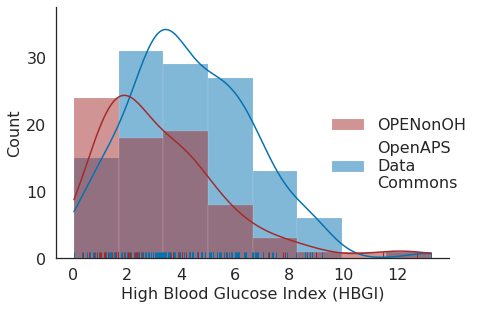

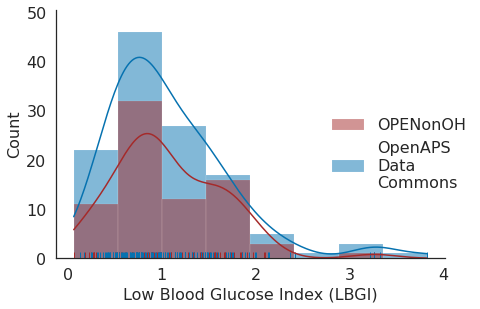

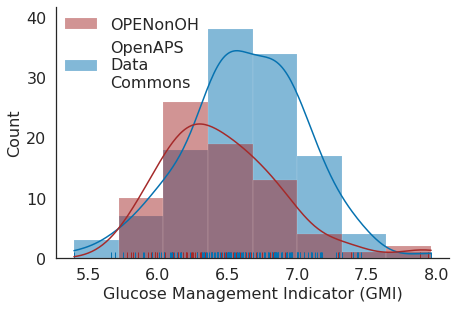

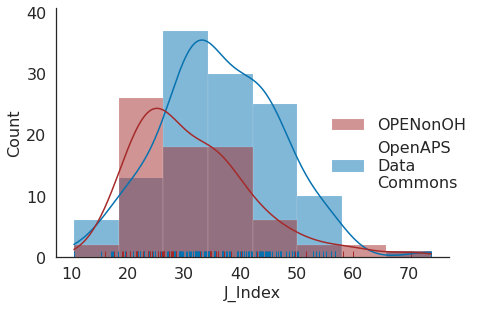

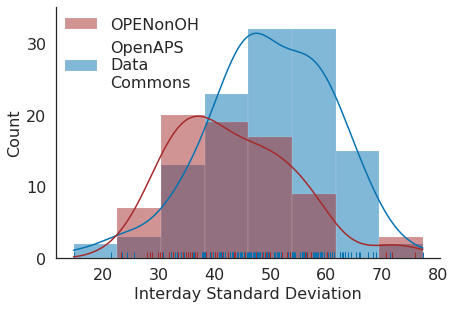

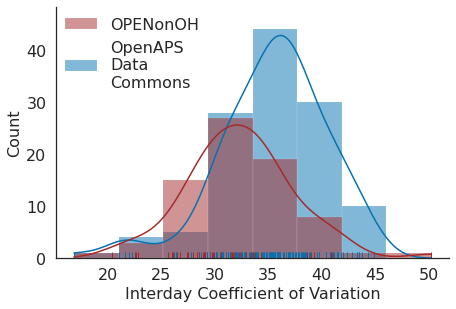

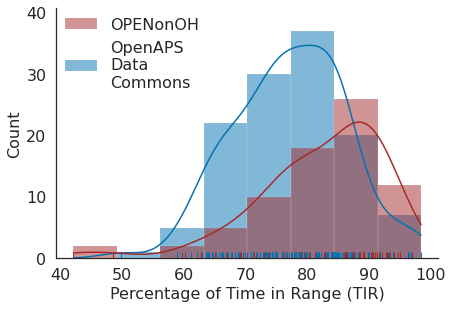

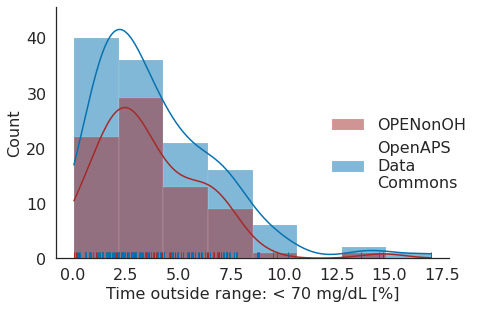

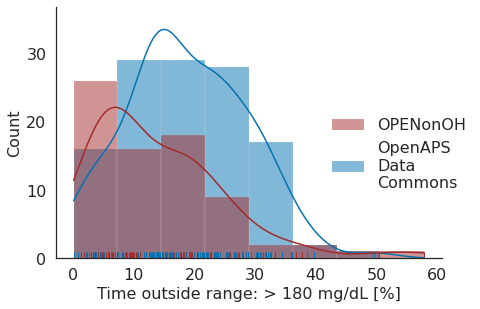

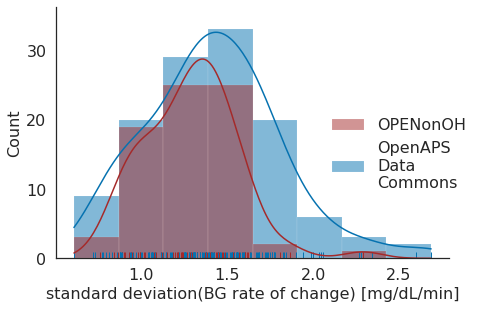

In [9]:
print(df3.columns)
print(df3["project"].unique())
momenta = []
# plot_kde2 does dataset comparison only, no male/female
x = plot_kde2(df3, 'HBGI', 'High Blood Glucose Index (HBGI)') 
momenta.append(x)
x = plot_kde2(df3, 'LGBI', 'Low Blood Glucose Index (LBGI)')
momenta.append(x)
x = plot_kde2(df3, 'GMI', 'Glucose Management Indicator (GMI)', True)
momenta.append(x)
x = plot_kde2(df3, 'J_index', 'J_Index')
momenta.append(x)
x = plot_kde2(df3, 'interdaysd', 'Interday Standard Deviation', True)
momenta.append(x)
x = plot_kde2(df3, 'interdaycv', 'Interday Coefficient of Variation', True)
momenta.append(x)
x = plot_kde2(df3, 'TIR', 'Percentage of Time in Range (TIR)', True)
momenta.append(x)
#x = plot_kde2(df3, 'TOR', 'Percentage of Time Outside Range (TOR)')
#momenta.append(x)
x = plot_kde2(df3, 'TOR<70', 'Time outside range: < 70 mg/dL [%]')
momenta.append(x)
x = plot_kde2(df3, 'TOR>180', 'Time outside range: > 180 mg/dL [%]')
momenta.append(x)
x = plot_kde2(df3, 'bg_roc_stds', 'standard deviation(BG rate of change) [mg/dL/min]')
momenta.append(x)

df_out = pd.DataFrame(momenta, columns=['mean_x', 'std_x', 'min_x', 'max_x', 'median_x', 'q1_x', 'q3_x', 'IQR_x', 'n_x', 'skew_x', 'kurtosis_x', 'mean_y', 
    'std_y', 'min_y', 'max_y', 'median_y', 'q1_y', 'q3_y', 'IQR_y', 'n_y', 'skew_y', 'kurtosis_y', 'z_statistic', 'p_value', 
    'ks_statistic', 'p_value_ks', 'mw_statistic', 'p_value_mw'])
df_out.index = ['HBGI', 'LBGI', 'GMI', 'J_index', 'interdaysd', 'interdaycv', 'TIR', 'TOR']


In [60]:
print(df_out)
df_out.to_csv("momenta.csv")

      mean_x      std_x      min_x      max_x   median_x       q1_x  \
0   4.356961   2.278247   0.032707  13.249534   3.954945   2.829733   
1   1.086480   0.654695   0.133531   3.822956   0.950067   0.636706   
2   6.634876   0.425091   5.396365   7.964080   6.627455   6.384457   
3  36.416946  10.483748  10.389813  73.929880  35.487742  29.708257   
4  49.750394  11.215002  14.707814  77.331936  49.338118  43.130734   
5  35.433650   5.038295  16.862385  44.937481  35.869040  32.422746   
6  77.256885   8.952792  49.750000  98.450000  77.910000  71.177500   
7   4.006967   2.963419   0.230000  16.970000   3.220000   1.787500   
8  18.736148   9.768577   0.050000  49.670000  17.140000  12.717500   
9   1.417367   0.389725   0.606594   2.687791   1.406631   1.150276   

        q3_x      IQR_x  n_x    skew_x  ...      IQR_y  n_y    skew_y  \
0   5.887944   3.058211  122  0.589118  ...   3.058211   75  1.616991   
1   1.418320   0.781614  122  1.571539  ...   0.781614   75  0.823548   

In [10]:
def plot_kde(df, var, xlabel, move_legend=False):
    sns.set_theme(context="notebook", style="white")
    #sns.set_theme(rc={'alpha' : 0.5, 'linewidth' : 0.1, 'kde' : True, 'rug':True})
    
    df[var] = df[var].astype(float)

    #plt.rcParams.update({'font.size': 30, 'legend.fontsize': 18, 'legend.title_fontsize': 20, 'legend.title_fontcolor': "yellow"})
    plt.rcParams.update({'font.size': 30, 'legend.fontsize': 16, 'legend.title_fontsize': 16, 'axes.labelsize': 16, 'axes.titlesize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16})
    nbins = 8  # number of bins
    fg= sns.displot(df,
                x=df[var],
                hue=df['gender'],
                palette=["brown", "#0672B0"],
                alpha=0.5,
                linewidth=0.1,
                bins=nbins,
                kde=True, 
                rug=True)
    plt.xlabel(xlabel)
    plt.tight_layout()
    if move_legend: 
        sns.move_legend(fg, title="", loc='upper left', bbox_to_anchor=(0.25, 0.85), ncol=1)
    else: 
        sns.set_legend_title(fg, title="xxx", prop={"size": 20})        
        #sns.move_legend(fg, title="", loc='center right', ncol=1)
    plt.savefig("OPENonOH_gender_kde_"+var+".png")

    # calculate stats:
    x = df.loc[df['gender']=='Female', var].tolist()
    IQR_x = np.percentile(x, 75) - np.percentile(x, 25)
    y = df.loc[df['gender']=='Male', var].tolist()
    IQR_y = np.percentile(x, 75) - np.percentile(x, 25)
    
    z_statistic, p_value = smws.ztest(x, y)
    ks_statistic, p_value_ks = ks_2samp(x, y)
    mw_statistic, p_value_mw = mannwhitneyu(x, y)

    out = [np.mean(x), np.std(x), np.min(x), np.max(x), np.median(x), np.percentile(x, 25), np.percentile(x, 75), IQR_x, len(x), skew(x), kurtosis(x)]
    out.extend([np.mean(y), np.std(y), np.min(y), np.max(y), np.median(y), np.percentile(y, 25), np.percentile(y, 75), IQR_y, len(y), skew(y), kurtosis(y)])
    out.extend([z_statistic, p_value, ks_statistic, p_value_ks, mw_statistic, p_value_mw])
    return out

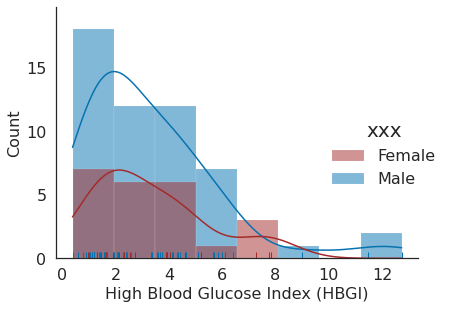

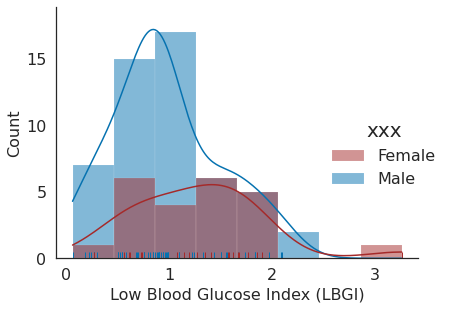

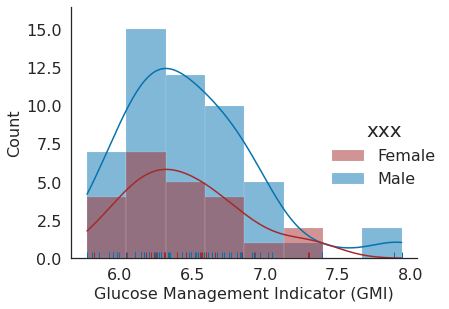

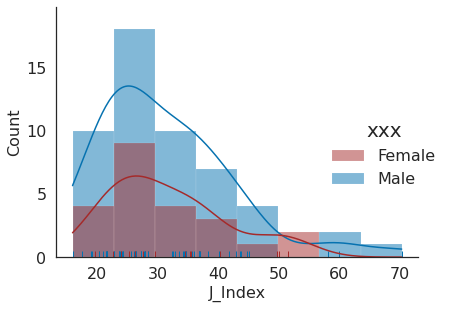

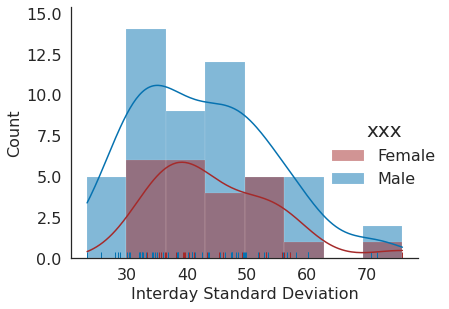

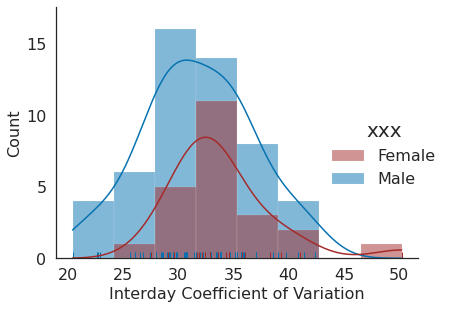

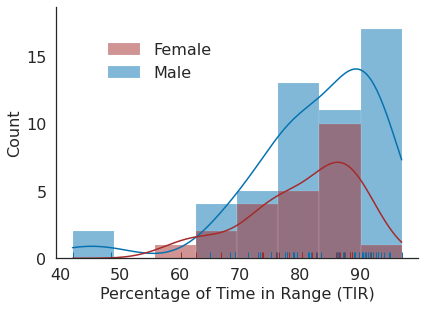

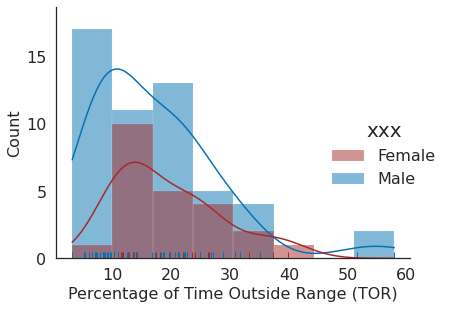

In [11]:
momenta_gender = []
x = plot_kde(df1, 'HBGI', 'High Blood Glucose Index (HBGI)')
momenta_gender.append(x)
x = plot_kde(df1, 'LGBI', 'Low Blood Glucose Index (LBGI)')
momenta_gender.append(x)
x = plot_kde(df1, 'GMI', 'Glucose Management Indicator (GMI)')
momenta_gender.append(x)
x = plot_kde(df1, 'J_index', 'J_Index')
momenta_gender.append(x)
x = plot_kde(df1, 'interdaysd', 'Interday Standard Deviation')
momenta_gender.append(x)
x = plot_kde(df1, 'interdaycv', 'Interday Coefficient of Variation')
momenta_gender.append(x)
x = plot_kde(df1, 'TIR', 'Percentage of Time in Range (TIR)', True)
momenta_gender.append(x)
x= plot_kde(df1, 'TOR', 'Percentage of Time Outside Range (TOR)')
momenta_gender.append(x)

df_gender_out = pd.DataFrame(momenta_gender, columns=['mean_x', 'std_x', 'min_x', 'max_x', 'median_x', 'q1_x', 'q3_x', 'IQR_x', 'n_x', 'skew_x', 'kurtosis_x', 'mean_y', 
    'std_y', 'min_y', 'max_y', 'median_y', 'q1_y', 'q3_y', 'IQR_y', 'n_y', 'skew_y', 'kurtosis_y', 'z_statistic', 'p_value', 
    'ks_statistic', 'p_value_ks', 'mw_statistic', 'p_value_mw'])

In [64]:
df_gender_out.index = ['HBGI', 'LBGI', 'GMI', 'J_index', 'interdaysd', 'interdaycv', 'TIR', 'TOR']
df_gender_out.to_csv("moment_gender.csv")

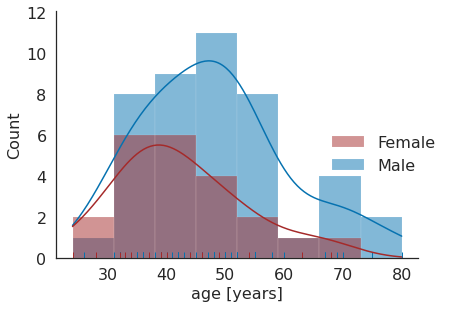

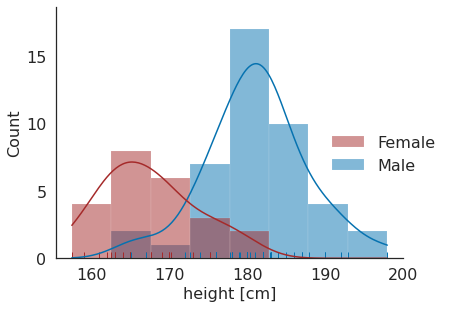

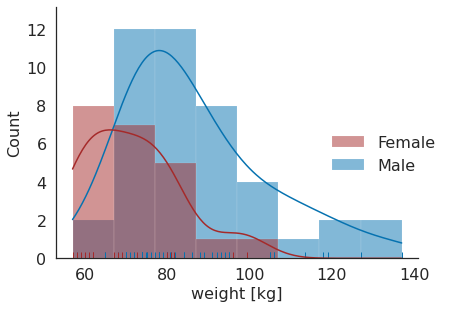

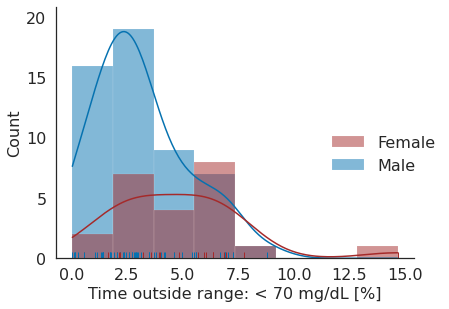

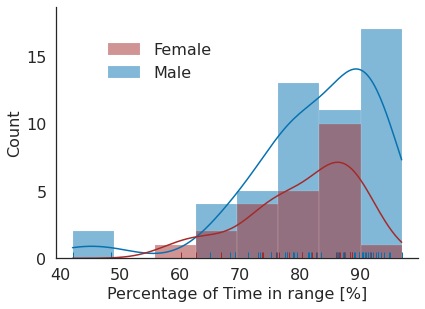

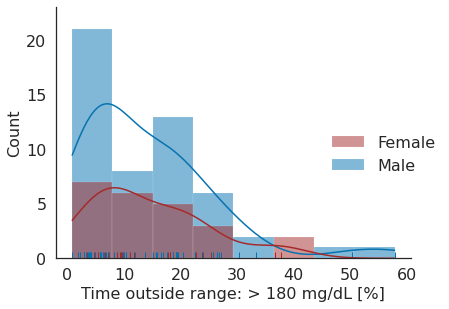

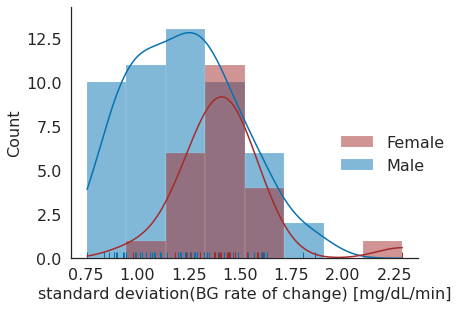

In [62]:
momenta_gender2 = []
x = plot_kde(df1, 'age', 'age [years]')
momenta_gender2.append(x)
x = plot_kde(df1, 'height', 'height [cm]')
momenta_gender2.append(x)
x = plot_kde(df1, 'weight', 'weight [kg]')
momenta_gender2.append(x)
x = plot_kde(df1, 'TOR<70', 'Time outside range: < 70 mg/dL [%]')
momenta_gender2.append(x)
x = plot_kde(df1, 'TIR', 'Percentage of Time in range [%]', True)
momenta_gender2.append(x)
x = plot_kde(df1, 'TOR>180', 'Time outside range: > 180 mg/dL [%]')
momenta_gender2.append(x)
x = plot_kde(df1, 'bg_roc_stds', 'standard deviation(BG rate of change) [mg/dL/min]')
momenta_gender2.append(x)

df_gender_out2 = pd.DataFrame(momenta_gender2, columns=['mean_x', 'std_x', 'min_x', 'max_x', 'median_x', 'q1_x', 'q3_x', 'IQR_x', 'n_x', 'skew_x', 'kurtosis_x', 'mean_y', 
    'std_y', 'min_y', 'max_y', 'median_y', 'q1_y', 'q3_y', 'IQR_y', 'n_y', 'skew_y', 'kurtosis_y', 'z_statistic', 'p_value', 
    'ks_statistic', 'p_value_ks', 'mw_statistic', 'p_value_mw'])

In [63]:
df_gender_out2.index = ['age', 'height', 'weight', 'TOR<70', 'TIR', 'TOR>180', 'bg_roc_stds']
df_gender_out2.to_csv("moment_gender2.csv")

Text(0.5, 15.440000000000012, 'Interday Coefficient of Variation')

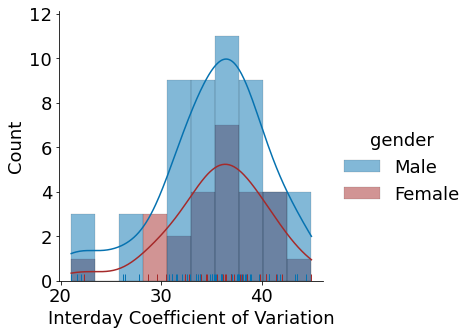

In [17]:
sns.displot(complete_statistics,
            x=complete_statistics['interdaycv'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Interday Coefficient of Variation')

Text(0.5, 15.440000000000012, 'Standard Deviation for Glucose Rate of Change (mg/dL/minute)')

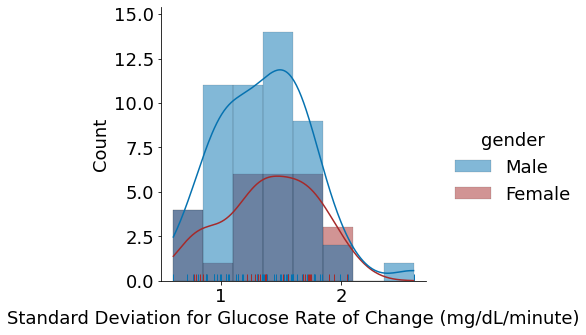

In [18]:
sns.displot(complete_statistics,
            x=complete_statistics['bg_roc_stds'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Standard Deviation for Glucose Rate of Change (mg/dL/minute)')

Text(0.5, 15.440000000000012, 'Mean Glucose (mg/dL)')

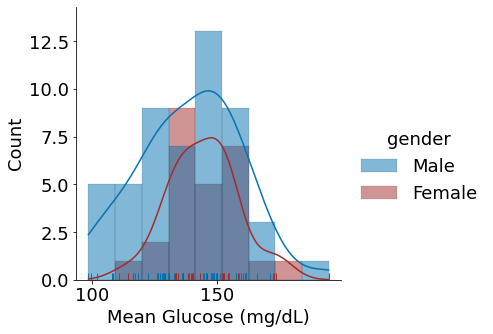

In [19]:
sns.displot(complete_statistics,
            x=complete_statistics['mean'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Mean Glucose (mg/dL)')

Text(0.5, 15.440000000000012, 'J_Index')

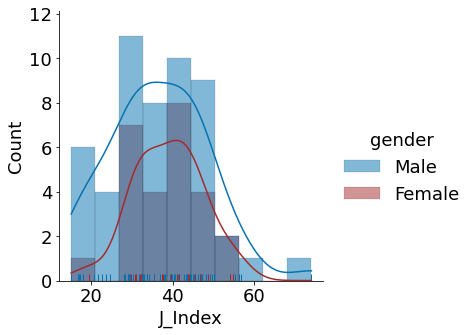

In [20]:
sns.displot(complete_statistics,
            x=complete_statistics['J_index'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('J_Index')

Text(0.5, 15.440000000000012, 'Low Blood Glucose Index (LBGI)')

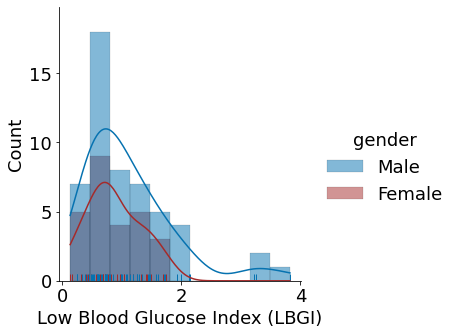

In [21]:
sns.displot(complete_statistics,
            x=complete_statistics['LGBI'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Low Blood Glucose Index (LBGI)')

Text(0.5, 15.440000000000012, 'High Blood Glucose Index (HBGI)')

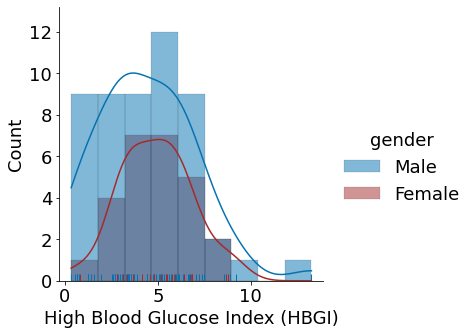

In [22]:
sns.displot(complete_statistics,
            x=complete_statistics['HBGI'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('High Blood Glucose Index (HBGI)')

Text(0.5, 15.440000000000012, 'Glucose Management Indicator (GMI)')

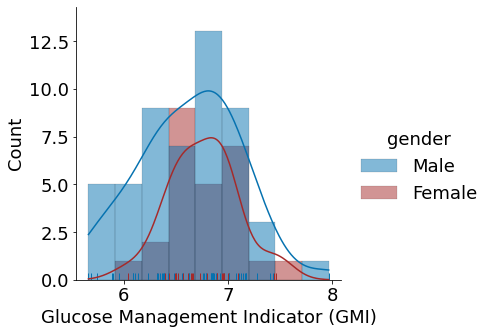

In [23]:
sns.displot(complete_statistics,
            x=complete_statistics['GMI'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Glucose Management Indicator (GMI)')

Text(0.5, 15.440000000000012, 'Percentage of Time in Range (TIR)')

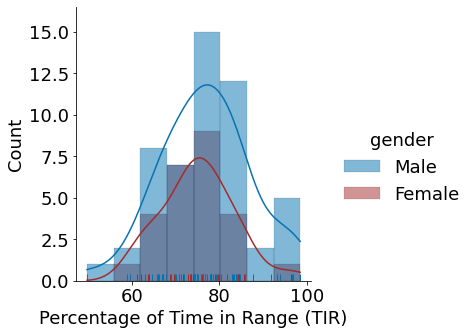

In [24]:
sns.displot(complete_statistics,
            x=complete_statistics['TIR [%]'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Percentage of Time in Range (TIR)')

Text(0.5, 15.440000000000012, 'Percentage of Time Outside Range (POR)')

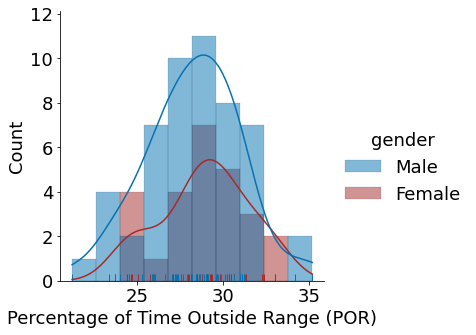

In [25]:
sns.displot(complete_statistics,
            x=complete_statistics['TOR'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Percentage of Time Outside Range (TOR)')

Text(0.5, 15.440000000000012, 'Daily Basal Insulin Units')

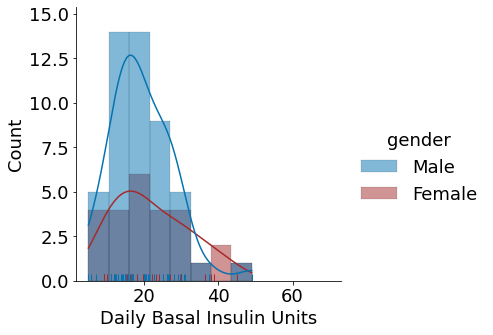

In [26]:
sns.displot(complete_statistics,
            x=complete_statistics['dailyBasalInsulinUnits'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Daily Basal Insulin Units')

Text(0.5, 15.440000000000012, 'Daily Insulin Units')

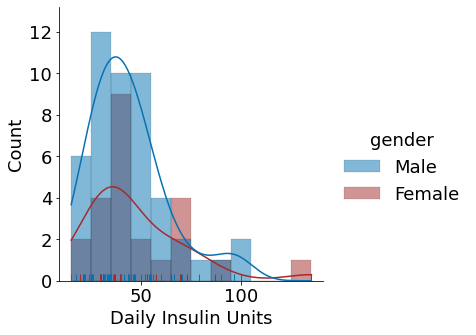

In [27]:
sns.displot(complete_statistics,
            x=complete_statistics['dailyInsulinUnits'],
            hue=complete_statistics['gender'],
            palette=["#0672B0", "brown"],
            alpha=0.5,
            linewidth=0.1,
            kde=True,
            rug=True)
plt.xlabel('Daily Insulin Units')